# Classifier Comparison Tutorial
## In this example, we demonstrate how the cleanlab package can be used with any classifier and dataset distribution. We compare performance across 10 classifiers and 4 dataset distributions in both the binary and multiclass classification setting.

### Some of the graphical components of this tutorial were adapted from
* http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
* http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html




In [1]:
# Python 2 and 3 compatibility
from __future__ import print_function, absolute_import, division, unicode_literals, with_statement

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from cleanlab.classification import LearningWithNoisyLabels
from cleanlab.noise_generation import generate_noise_matrix_from_trace
from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import print_noise_matrix
import copy

# Silence neural network SGD convergence warnings.
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [3]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_linearly_seperable_dataset(n_classes = 3, n_samples = 300):
    X, y = make_classification(n_samples = n_samples, n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1, n_classes=n_classes)
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    return (X, y)

## Sparsity of noise matrix
#### As is, the code below will generate non-sparse noise matrices (all non-zero noise rates). You can also generate and use sparse noise matrices by increasing **`FRAC_ZERO_NOISE_RATES`** (below). Examples:
```python
~DENSE~ Noise Matrix / Noisy Channel P(s|y):
	  y=0   y=1   y=2
      ----  ----  ---
s=0 | 0.59  0.04  0.33
s=1 | 0.12  0.93  0.14
s=2 | 0.29  0.03  0.53

~SPARSE~ Noise Matrix / Noisy Channel P(s|y):
	  y=0  y=1   y=2
      ---  ---   ---
s=0 | 0.6  0     0.3
s=1 | 0.4  0.95  0
s=2 | 0    0     0.7
```
#### Higher sparsity typically is more difficult because it focuses all the noise on just a few label changes. Although the overall accuracy is typically lower, higher sparsity tends to lead to more improvement when using **cleanlab** relative to learning with the noisy labels.

In [4]:
# Initalization.

# Set the sparsity of the noise matrix.
FRAC_ZERO_NOISE_RATES = 0.0 # Consider increasing to 0.5
# A proxy for the fraction of labels that are correct.
avg_trace = 0.65 # ~35% wrong labels. Increasing makes the problem easier.
# Amount of data for each dataset.
dataset_size = 400 # Try 250 or 400 to use less or more data.
# Step size in the mesh.
h = .02  

names = ["Naive Bayes", "LogisticReg", "K-NN (K=3)", 
         "Linear SVM", "RBF SVM","Rand Forest", 
         "Neural Net", "AdaBoost", "QDA"]

classifiers = [
    GaussianNB(),
    LogisticRegression(random_state=0, solver = 'lbfgs', multi_class = 'auto'),
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, random_state=0, ),
    AdaBoostClassifier(random_state=0),
    QuadraticDiscriminantAnalysis()
]

dataset_names = [
    'Linear (m = 4)',
    'Linear (m = 3)',
    'Moons (m = 2)',
    'Circles (m = 2)',
]

# Hyper-parameters for LearningWithNoisyLabels() classifier
params = {
    "cv_n_folds": [5], # Default. Keep as default for fair comparison.
    "prune_method": ['prune_by_noise_rate', 'prune_by_class', 'both'],
    "converge_latent_estimates": [False, True],
}

experiments = [
    'no_label_errors',
    'label_errors_no_rp',
    'label_errors_with_rp',
]

datasets = [
    make_linearly_seperable_dataset(n_classes=4, n_samples=4*dataset_size),
    make_linearly_seperable_dataset(n_classes=3, n_samples=3*dataset_size),
    make_moons(n_samples=2*dataset_size, noise=0.3, random_state=0), # 2 classes
    make_circles(n_samples=2*dataset_size, noise=0.2, factor=0.5, random_state=1), # 2 classes
]

In [5]:
results = []
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=1)
    num_classes = len(np.unique(y_train))
    print('Running dataset', ds_cnt + 1, 'with m =', num_classes, 'classes and n =', len(X_train), 'training examples.')

    # CONFIDENT LEARNING COMPONENT

    np.random.seed(seed=0)

    py = np.bincount(y_train) / float(len(y_train))
    # Generate the noisy channel to characterize the label errors.
    noise_matrix = generate_noise_matrix_from_trace(
        K = num_classes,
        trace = num_classes * avg_trace, 
        py = py,
        frac_zero_noise_rates = FRAC_ZERO_NOISE_RATES,
    )
    print_noise_matrix(noise_matrix)
    np.random.seed(seed=1)
    # Create the noisy labels. This method is exact w.r.t. the noise_matrix.
    y_train_w_errors = generate_noisy_labels(y_train, noise_matrix)


    clf_results = {}
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        # Create four copies of the classifier.
        # perf_label_clf - Will be trained on the hidden, noise-free labels
        # noisy_clf - Will be trained on the noisy labels
        # noisy_clf_w_rp - Will be trained on the noisy labels using LearningWithNoisyLabels

        clfs = [copy.deepcopy(clf) for i in range(len(experiments))]
        perf_label_clf, noisy_clf, noisy_clf_w_rp = clfs
        # Classifier (trained without label errors)
        perf_label_clf.fit(X_train, y_train)
        perf_label_score = perf_label_clf.score(X_test, y_test)
        # Classifier (trained with label errors)
        noisy_clf.fit(X_train, y_train_w_errors)
        noisy_score = noisy_clf.score(X_test, y_test)
        # Classifier + RP (trained with label errors)
        rp = LearningWithNoisyLabels(noisy_clf_w_rp)
        rp.fit(X_train, y_train_w_errors)
        noisy_score_w_rp = rp.clf.score(X_test, y_test)

        # Store results for each classifier in a dict with key = clf_name.
        clf_results[name] = {
            'clfs' : clfs,
            "perf_label_score" : perf_label_score,
            "noisy_score" : noisy_score,
            "noisy_score_w_rp" : noisy_score_w_rp,           
        }

    results.append({
        "X" : X,
        "X_train" : X_train,
        "y_train" : y_train,
        "y_train_w_errors" : y_train_w_errors,
        "num_classes" : num_classes,
        "py" : py,
        "noise_matrix" : noise_matrix,
        "clf_results" : clf_results,
    })

Running dataset 1 with m = 4 classes and n = 720 training examples.

 Noise Matrix (aka Noisy Channel) P(s|y) of shape (4, 4)
 p(s|y)	y=0	y=1	y=2	y=3
	---	---	---	---
s=0 |	0.55	0.01	0.07	0.06
s=1 |	0.22	0.87	0.24	0.02
s=2 |	0.12	0.04	0.64	0.38
s=3 |	0.11	0.08	0.05	0.54
	Trace(matrix) = 2.6

Running dataset 2 with m = 3 classes and n = 540 training examples.

 Noise Matrix (aka Noisy Channel) P(s|y) of shape (3, 3)
 p(s|y)	y=0	y=1	y=2
	---	---	---
s=0 |	0.52	0.1	0.34
s=1 |	0.2	0.82	0.05
s=2 |	0.28	0.07	0.61
	Trace(matrix) = 1.95

Running dataset 3 with m = 2 classes and n = 360 training examples.

 Noise Matrix (aka Noisy Channel) P(s|y) of shape (2, 2)
 p(s|y)	y=0	y=1
	---	---
s=0 |	0.5	0.2
s=1 |	0.5	0.8
	Trace(matrix) = 1.3

Running dataset 4 with m = 2 classes and n = 360 training examples.

 Noise Matrix (aka Noisy Channel) P(s|y) of shape (2, 2)
 p(s|y)	y=0	y=1
	---	---
s=0 |	0.5	0.2
s=1 |	0.5	0.8
	Trace(matrix) = 1.3



Experiment 1: Decision boundary plotted is No label errors


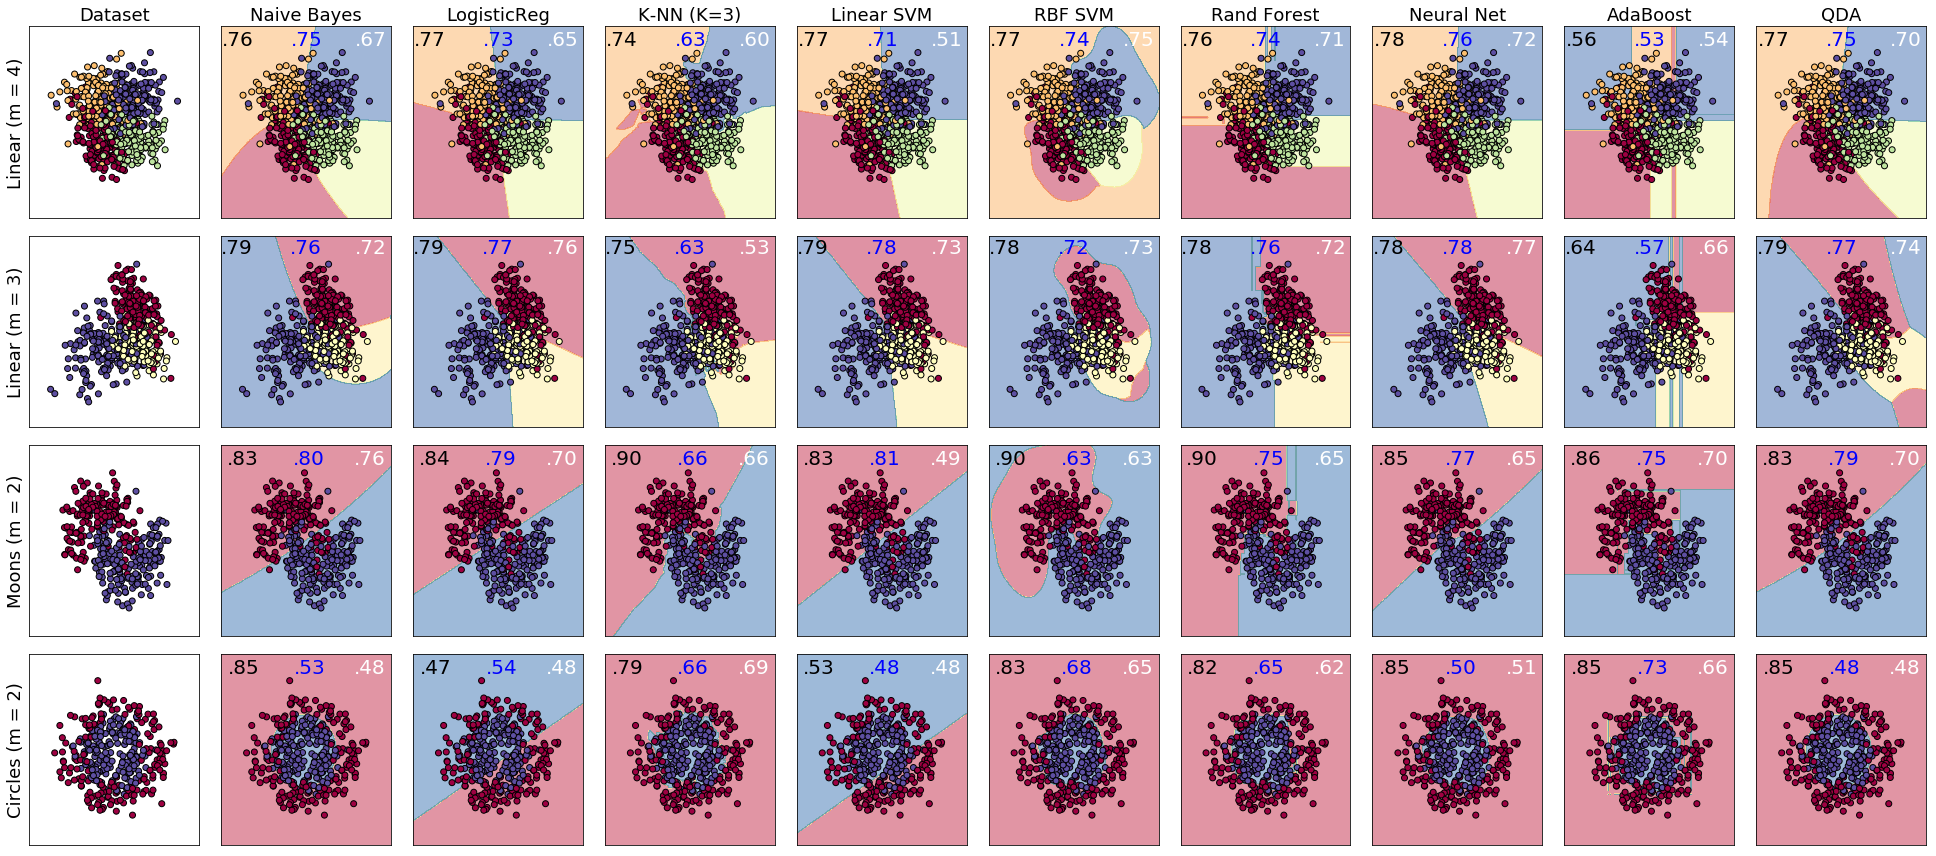

Experiment 2: Decision boundary plotted is Label errors no rp


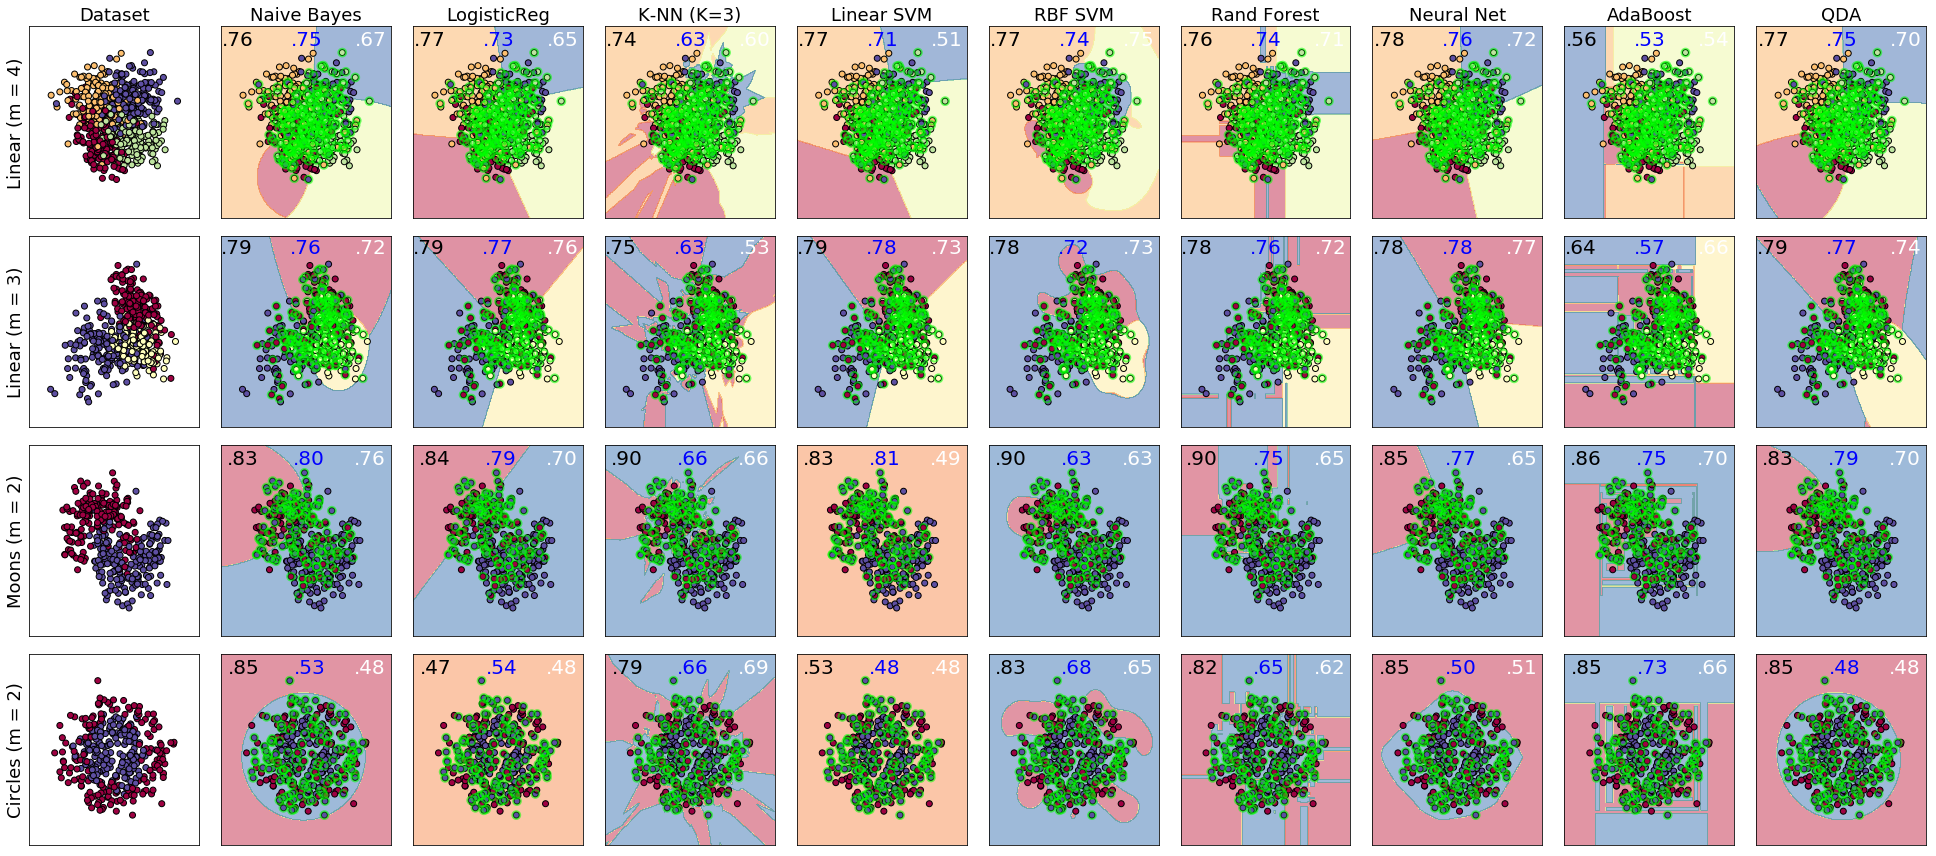

Experiment 3: Decision boundary plotted is Label errors with rp


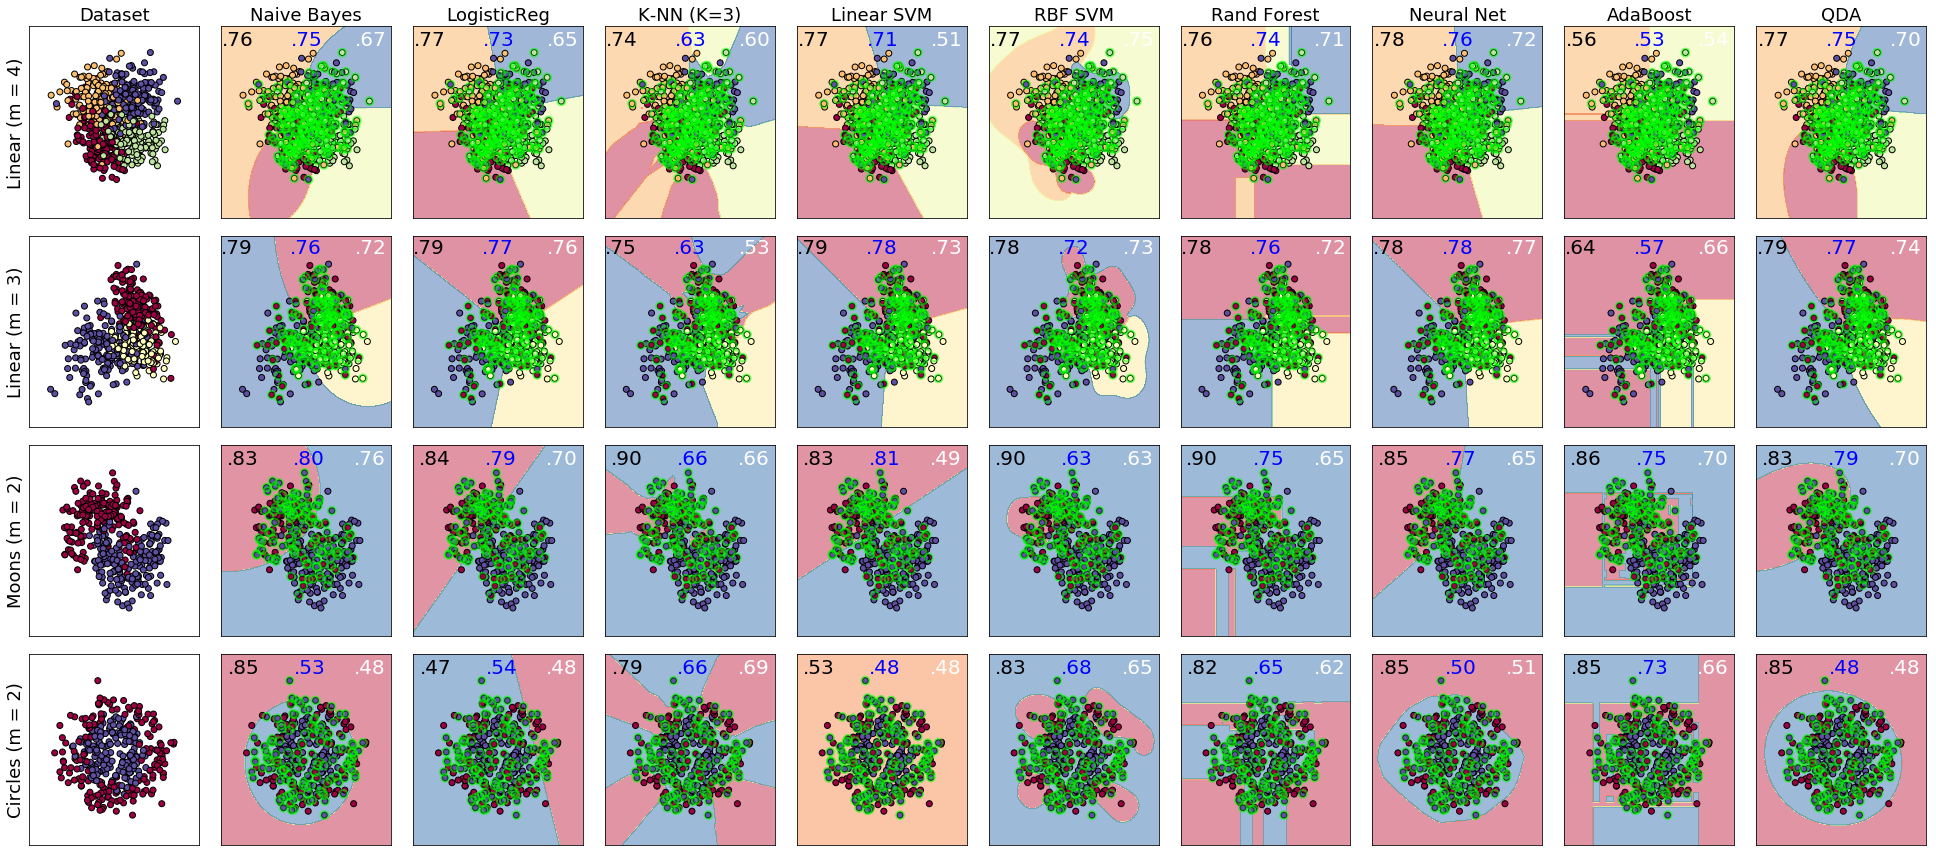

In [6]:
save_figures = True

for e_i, experiment in enumerate([
    'no_label_errors', 
    'label_errors_no_rp', 
    'label_errors_with_rp',
]):
    print(
        'Experiment '+str(e_i+1)+':', 
        "Decision boundary plotted is",
        " ".join(experiment.split('_')).capitalize(),
    )
    print("="*80)
    figure = plt.figure(figsize=(27, 12))
    i = 1
    
    # iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        # Fetch the data we generated above, for plotting.
        for key,val in results[ds_cnt].items():
            exec(key + '=val')
        
        # Plot the dataset first    
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)
        cm = plt.cm.coolwarm
        cm = plt.cm.nipy_spectral
        cm = plt.cm.Spectral
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        ax.set_ylabel(dataset_names[ds_cnt], fontsize=18)
        if ds_cnt == 0:
            ax.set_title("Dataset", fontsize=18)
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm,
                   edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

        # iterate over classifiers
        for name, clf in zip(names, classifiers):
            # Fetch the classifier computation results.
            for key,val in clf_results[name].items():
                exec(key + '=val')
            
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            
            # This is the clf we'll use to plot the boundary conditions
            clf = clfs[e_i]
            
            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

            plot_contours(ax, clf, xx, yy, cmap=cm, alpha=0.5)

            # Plot the training points
            ax.scatter(
                X_train[:, 0], 
                X_train[:, 1], 
                c=y_train if experiment == 'no_label_errors' else y_train_w_errors, 
                cmap=cm,
                edgecolors='k',
            )            
            if experiment != 'no_label_errors':
                # Plot the label errors
                ax.scatter(
                    X_train[y_train != y_train_w_errors][:, 0],
                    X_train[y_train != y_train_w_errors][:, 1],
                    edgecolors='lime',
                    s=60,
                    facecolors='none',
                    alpha=0.55,
                    linewidth=2,
                )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name, fontsize=18)
            ax.text(xx.min() + 1.5, yy.max() - .7, ('%.2f' % perf_label_score).lstrip('0'),
                    size=20, horizontalalignment='right', color='black')
            ax.text(xx.max() - .2, yy.max() - .7, ('%.2f' % noisy_score).lstrip('0'),
                    size=20, horizontalalignment='right', color='white')
            ax.text(xx.mean() + .75, yy.max() - .7, ('%.2f' % noisy_score_w_rp).lstrip('0'),
                    size=20, horizontalalignment='right', color='blue')
            i += 1

    plt.tight_layout()
    if save_figures:
        _ = plt.savefig('../img/{}.png'.format(experiment), pad_inches=0.0, bbox_inches='tight')
    
    plt.show()